# 🚀 Next Steps: Advanced Analysis & Machine Learning

Now that we have successfully processed proteins, ligands, and pockets into standardized 3D grids, we can proceed with advanced analysis and machine learning applications.

## 1) Imports

In [1]:
!pip install rdkit

!pip install tqdm

!pip install scikit-learn

!pip install ovito


In [2]:
# # Fix OpenMP library conflicts and other potential issues
import os
import sys
import gc

# Handle OpenMP library conflicts
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# # Limit threading to reduce memory contention
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"
# os.environ["OMP_NUM_THREADS"] = "1"

# # Force PyTorch to use CPU instead of GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# # Enable aggressive garbage collection
# gc.enable()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Import F for functional API like F.mse_loss
from torch.utils.data import DataLoader # Ensure DataLoader is imported here if not already

In [4]:
import numpy as np
import torch
from itertools import product
from typing import Sequence, Tuple, Optional
import time
import pandas as pd
import os
import glob
import math
import matplotlib.pyplot as plt
import json
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Crippen
import os
import glob
from pathlib import Path
from typing import List, Tuple, Dict, Optional, Union
import logging
from dataclasses import dataclass
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import time
import pickle
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# ovito imports
import numpy as np
from ovito.io import export_file
from ovito.pipeline import StaticSource, Pipeline
from ovito.data import Particles, ParticleType
from ovito.modifiers import SelectTypeModifier, ColorCodingModifier
import os
import json

In [6]:
os.getcwd()

file_path = "step4_outputs/model_ready_data/pocket_data/pocket_grids.npz"

if os.path.exists(file_path):
    protein_grids = np.load(file_path)
    print("File loaded successfully.")
    print("Shape:", protein_grids.shape)
else:
    print("File not found:", file_path)

File not found: step4_outputs/model_ready_data/pocket_data/pocket_grids.npz


## 2) load it processed data from files prepped in step4

In [7]:
import os
import numpy as np
import json

print("Loading all processed molecular data...")

# Load protein data
pocket_grids = None
if os.path.exists("model_ready_data/pocket_data/pocket_grids.npz"):
    pocket_grids = np.load("model_ready_data/pocket_data/pocket_grids.npz", allow_pickle=True)
    with open("model_ready_data/pocket_data/pocket_metadata.json", 'r') as f:
        pocket_metadata = json.load(f)
    # print(f" Loaded protein data: {pocket_grids.shape}")
else:
    print(f" ERROR: Protein data not found.")

# Load ligand data
ligand_grids = None
if os.path.exists("model_ready_data/ligand_data/ligand_data.npz"):
    ligand_grids = np.load("model_ready_data/ligand_data/ligand_data.npz", allow_pickle=True)
    with open("model_ready_data/ligand_data/ligand_metadata.json", 'r') as f:
        ligand_metadata = json.load(f)
    # print(f" Loaded ligand data: {ligand_grids.shape}")
else:
    print(f" ERROR: Ligand data not found.")


# Summary
print(f"\nComplete Dataset Summary:")
print(f"    Ligands: {len(ligand_grids) if ligand_grids is not None else 0} samples")
print(f"    Pockets: {len(pocket_grids) if pocket_grids is not None else 0} samples")

print('done')


Loading all processed molecular data...

Complete Dataset Summary:
    Ligands: 1 samples
    Pockets: 1 samples
done


## 3) create matching datasets

In [32]:
import numpy as np
import json
import os

print("Loading all processed molecular data...")

# Load ligand grids from .npz and extract actual array
ligand_npz_path = "model_ready_data/ligand_data/ligand_data.npz"
if os.path.exists(ligand_npz_path):
    ligand_npz = np.load(ligand_npz_path)
    ligand_grids = ligand_npz[ligand_npz.files[0]]  # extract first (and likely only) array
    with open("model_ready_data/ligand_data/ligand_metadata.json", 'r') as f:
        ligand_metadata = json.load(f)
    print(f"Loaded ligand grids shape: {ligand_grids.shape}")
else:
    raise FileNotFoundError(f"Ligand grids file not found: {ligand_npz_path}")

# Load pocket grids from .npz and extract actual array
pocket_npz_path = "model_ready_data/pocket_data/pocket_grids.npz"
if os.path.exists(pocket_npz_path):
    pocket_npz = np.load(pocket_npz_path)
    pocket_grids = pocket_npz[pocket_npz.files[0]]  # extract first array
    with open("model_ready_data/pocket_data/pocket_metadata.json", 'r') as f:
        pocket_metadata = json.load(f)
    print(f"Loaded pocket grids shape: {pocket_grids.shape}")
else:
    raise FileNotFoundError(f"Pocket grids file not found: {pocket_npz_path}")

# Extraction functions for successful entries with IDs
def extract_successful_ligands(metadata):
    return [(entry['ligand_id'], entry) for entry in metadata if entry.get('success') and 'ligand_id' in entry]

def extract_successful_pockets(metadata):
    return [(entry['pocket_id'], entry) for entry in metadata if entry.get('success') and 'pocket_id' in entry]

# Extract successful ligand and pocket entries
ligand_success = extract_successful_ligands(ligand_metadata)
pocket_success = extract_successful_pockets(pocket_metadata)

print(f"Successful entries:")
print(f"    Ligands: {len(ligand_success)}")
print(f"    Pockets: {len(pocket_success)}")

# Create ID to index mappings
ligand_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(ligand_success)}
pocket_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(pocket_success)}

# Find common ligand-pocket IDs
common_ids = set(ligand_ids.keys()) & set(pocket_ids.keys())
print(f"\nFound {len(common_ids)} ligand-pocket pairs with both components!")

# Sample for memory-efficient processing
max_samples = min(20, len(common_ids))
common_ids_sample = sorted(list(common_ids))[:max_samples]

matched_ligand_indices = [ligand_ids[mol_id] for mol_id in common_ids_sample]
matched_pocket_indices = [pocket_ids[mol_id] for mol_id in common_ids_sample]

# Batch extraction with memory error handling
try:
    batch_size = 16
    matched_ligands_list = []
    matched_pockets_list = []

    for i in range(0, len(matched_ligand_indices), batch_size):
        batch_end = min(i + batch_size, len(matched_ligand_indices))
        batch_ligand_idx = matched_ligand_indices[i:batch_end]
        batch_pocket_idx = matched_pocket_indices[i:batch_end]

        batch_ligands = ligand_grids[batch_ligand_idx]
        batch_pockets = pocket_grids[batch_pocket_idx]

        matched_ligands_list.append(batch_ligands)
        matched_pockets_list.append(batch_pockets)

    matched_ligands = np.concatenate(matched_ligands_list, axis=0)
    matched_pockets = np.concatenate(matched_pockets_list, axis=0)

except MemoryError as e:
    print(f"⚠️ Memory error encountered: {e}")
    print("Reducing sample size further...")

    max_samples = min(5, len(common_ids))
    common_ids_sample = sorted(list(common_ids))[:max_samples]
    matched_ligand_indices = [ligand_ids[mol_id] for mol_id in common_ids_sample]
    matched_pocket_indices = [pocket_ids[mol_id] for mol_id in common_ids_sample]

    print(f"Trying with only {max_samples} samples...")
    matched_ligands = ligand_grids[matched_ligand_indices]
    matched_pockets = pocket_grids[matched_pocket_indices]

print(f"\n✅ Matched Dataset Created Successfully!")
print(f"    Ligands shape: {matched_ligands.shape}")
print(f"    Pockets shape: {matched_pockets.shape}")
print(f"    Memory usage: {(matched_ligands.nbytes + matched_pockets.nbytes) / 1024**3:.3f} GB")

# Store common IDs
common_ids_list = common_ids_sample
print(f"    Sampled IDs: {common_ids_list[:5]}{'...' if len(common_ids_list) > 5 else ''}")

# Memory cleanup note
print(f"\n🧹 Memory cleanup...")
print(f"Before cleanup: ~{(ligand_grids.nbytes + pocket_grids.nbytes) / 1024**3:.3f} GB")
# Uncomment below if memory is tight
# del ligand_grids, pocket_grids
print("Large arrays kept in memory for further analysis.")

Loading all processed molecular data...
Loaded ligand grids shape: (191, 19, 48, 48, 48)
Loaded pocket grids shape: (191, 19, 48, 48, 48)
Successful entries:
    Ligands: 191
    Pockets: 191

Found 191 ligand-pocket pairs with both components!

✅ Matched Dataset Created Successfully!
    Ligands shape: (20, 19, 48, 48, 48)
    Pockets shape: (20, 19, 48, 48, 48)
    Memory usage: 0.313 GB
    Sampled IDs: ['1a30', '1bcu', '1bzc', '1c5z', '1eby']...

🧹 Memory cleanup...
Before cleanup: ~2.990 GB
Large arrays kept in memory for further analysis.


In [33]:
# print(ligand_metadata)
# print(f"Ligand metadata entries: {len(ligand_metadata)}")
# print("First 2 entries:")
# for entry in ligand_metadata[:2]:
#     print(entry)


## 4) Creating analysis functions so nothing crashes later on

In [34]:
print("Setting up memory-efficient analysis functions...")

def analyze_single_complex(ligand_idx, pocket_idx, complex_id):
    """Analyze a single molecular complex without loading all data into memory"""
    try:
        # Load single grids (expand dims to keep shape consistent)
        ligand_grid = ligand_grids[ligand_idx:ligand_idx+1]
        pocket_grid = pocket_grids[pocket_idx:pocket_idx+1]
        
        # Calculate properties
        ligand_occupancy = np.mean(ligand_grid > 0)
        pocket_occupancy = np.mean(pocket_grid > 0)
        
        # Calculate centers of mass
        ligand_com = calculate_center_of_mass(ligand_grid[0])
        pocket_com = calculate_center_of_mass(pocket_grid[0])
        
        return {
            'complex_id': complex_id,
            'ligand_occupancy': ligand_occupancy,
            'pocket_occupancy': pocket_occupancy,
            'ligand_com': ligand_com,
            'pocket_com': pocket_com
        }
    except Exception as e:
        print(f"Error analyzing complex {complex_id}: {e}")
        return None

def calculate_center_of_mass(grid):
    """Calculate center of mass for a 3D grid"""
    # Sum across channels to get total density
    total_density = np.sum(grid, axis=0)
    
    if np.sum(total_density) == 0:
        # Assuming default center for your grid shape (e.g., 64x64x64)
        return [total_density.shape[0] / 2, total_density.shape[1] / 2, total_density.shape[2] / 2]
    
    coords = np.mgrid[0:total_density.shape[0], 0:total_density.shape[1], 0:total_density.shape[2]]
    total_mass = np.sum(total_density)
    com_x = np.sum(coords[0] * total_density) / total_mass
    com_y = np.sum(coords[1] * total_density) / total_mass
    com_z = np.sum(coords[2] * total_density) / total_mass
    
    return [float(com_x), float(com_y), float(com_z)]

def create_memory_efficient_dataset(max_samples=100):
    """Create a dataset by analyzing ligand-pocket complexes one at a time"""
    print(f"Creating memory-efficient dataset with up to {max_samples} samples...")
    
    # Extract successful entries with IDs
    ligand_success = extract_successful_ligands(ligand_metadata)
    pocket_success = extract_successful_pockets(pocket_metadata)
    
    ligand_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(ligand_success)}
    pocket_ids = {mol_id: idx for idx, (mol_id, _) in enumerate(pocket_success)}
    
    common_ids = set(ligand_ids.keys()) & set(pocket_ids.keys())
    common_ids_sample = sorted(list(common_ids))[:max_samples]
    
    complex_analyses = []
    for i, mol_id in enumerate(common_ids_sample):
        print(f"  Analyzing complex {i+1}/{len(common_ids_sample)}: {mol_id}")
        
        ligand_idx = ligand_ids[mol_id]
        pocket_idx = pocket_ids[mol_id]
        
        analysis = analyze_single_complex(ligand_idx, pocket_idx, mol_id)
        if analysis:
            complex_analyses.append(analysis)
    
    return complex_analyses

# Create the memory-efficient dataset
efficient_dataset = create_memory_efficient_dataset(max_samples=188)
print(f"\nSuccessfully created dataset with {len(efficient_dataset)} complexes!")


Setting up memory-efficient analysis functions...
Creating memory-efficient dataset with up to 188 samples...
  Analyzing complex 1/188: 1a30
  Analyzing complex 2/188: 1bcu
  Analyzing complex 3/188: 1bzc
  Analyzing complex 4/188: 1c5z
  Analyzing complex 5/188: 1eby
  Analyzing complex 6/188: 1g2k
  Analyzing complex 7/188: 1k1i
  Analyzing complex 8/188: 1lpg
  Analyzing complex 9/188: 1mq6
  Analyzing complex 10/188: 1nc1
  Analyzing complex 11/188: 1nvq
  Analyzing complex 12/188: 1o0h
  Analyzing complex 13/188: 1o3f
  Analyzing complex 14/188: 1o5b
  Analyzing complex 15/188: 1owh
  Analyzing complex 16/188: 1oyt
  Analyzing complex 17/188: 1p1q
  Analyzing complex 18/188: 1q8u
  Analyzing complex 19/188: 1r5y
  Analyzing complex 20/188: 1s38
  Analyzing complex 21/188: 1sqa
  Analyzing complex 22/188: 1syi
  Analyzing complex 23/188: 1u1b
  Analyzing complex 24/188: 1uto
  Analyzing complex 25/188: 1vso
  Analyzing complex 26/188: 1w4o
  Analyzing complex 27/188: 1y6r
  Analyz

Creating memory-efficient visualizations...


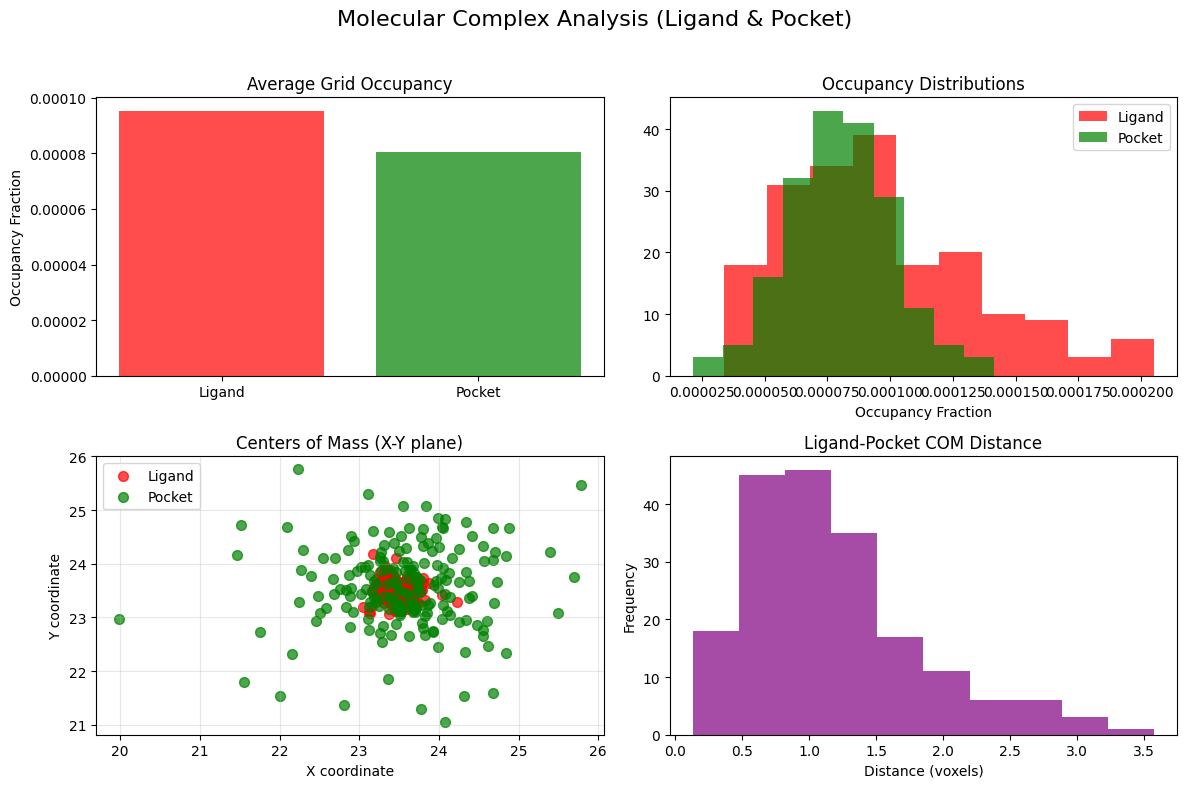


 Visualization complete!
   Dataset contains 188 molecular complexes
 Results saved to molecular_complex_analysis.json
   File size: 60.7 KB


In [35]:
print("Creating memory-efficient visualizations...")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def visualize_complex_properties(dataset):
    """Visualize properties of the molecular complexes (ligand + pocket only)"""
    if not dataset:
        print("No data to visualize")
        return
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(dataset)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Molecular Complex Analysis (Ligand & Pocket)', fontsize=16)
    
    # 1. Occupancy comparison
    axes[0, 0].bar(['Ligand', 'Pocket'], 
                   [df['ligand_occupancy'].mean(), df['pocket_occupancy'].mean()],
                   color=['red', 'green'], alpha=0.7)
    axes[0, 0].set_title('Average Grid Occupancy')
    axes[0, 0].set_ylabel('Occupancy Fraction')
    
    # 2. Occupancy distributions
    axes[0, 1].hist(df['ligand_occupancy'], alpha=0.7, label='Ligand', color='red', bins=10)
    axes[0, 1].hist(df['pocket_occupancy'], alpha=0.7, label='Pocket', color='green', bins=10)
    axes[0, 1].set_title('Occupancy Distributions')
    axes[0, 1].set_xlabel('Occupancy Fraction')
    axes[0, 1].legend()
    
    # 3. Center of mass scatter (X vs Y)
    ligand_coms = np.array([x['ligand_com'] for x in dataset])
    pocket_coms = np.array([x['pocket_com'] for x in dataset])
    
    axes[1, 0].scatter(ligand_coms[:, 0], ligand_coms[:, 1], 
                       label='Ligand', color='red', alpha=0.7, s=50)
    axes[1, 0].scatter(pocket_coms[:, 0], pocket_coms[:, 1], 
                       label='Pocket', color='green', alpha=0.7, s=50)
    axes[1, 0].set_title('Centers of Mass (X-Y plane)')
    axes[1, 0].set_xlabel('X coordinate')
    axes[1, 0].set_ylabel('Y coordinate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Distance between ligand and pocket COMs
    distances = np.linalg.norm(ligand_coms - pocket_coms, axis=1)
    axes[1, 1].hist(distances, bins=10, color='purple', alpha=0.7)
    axes[1, 1].set_title('Ligand-Pocket COM Distance')
    axes[1, 1].set_xlabel('Distance (voxels)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    return df

# Visualize the dataset
if 'efficient_dataset' in locals() and efficient_dataset:
    summary_df = visualize_complex_properties(efficient_dataset)
    print("\n Visualization complete!")
    print(f"   Dataset contains {len(efficient_dataset)} molecular complexes")
else:
    print("⚠️  No dataset available for visualization")

def save_memory_efficient_results(dataset, filename="molecular_complex_analysis.json"):
    """Save analysis results to avoid recomputation"""
    if dataset:
        import json
        with open(filename, 'w') as f:
            json.dump(dataset, f, indent=2)
        print(f" Results saved to {filename}")
        print(f"   File size: {os.path.getsize(filename) / 1024:.1f} KB")

# Save results
if 'efficient_dataset' in locals():
    save_memory_efficient_results(efficient_dataset)


## 5) Nonfunctional visualizations (just for fun)

 Creating advanced visualizations of molecular complexes...
Visualizing sample molecular complexes...

 Visualizing complex: 1a30


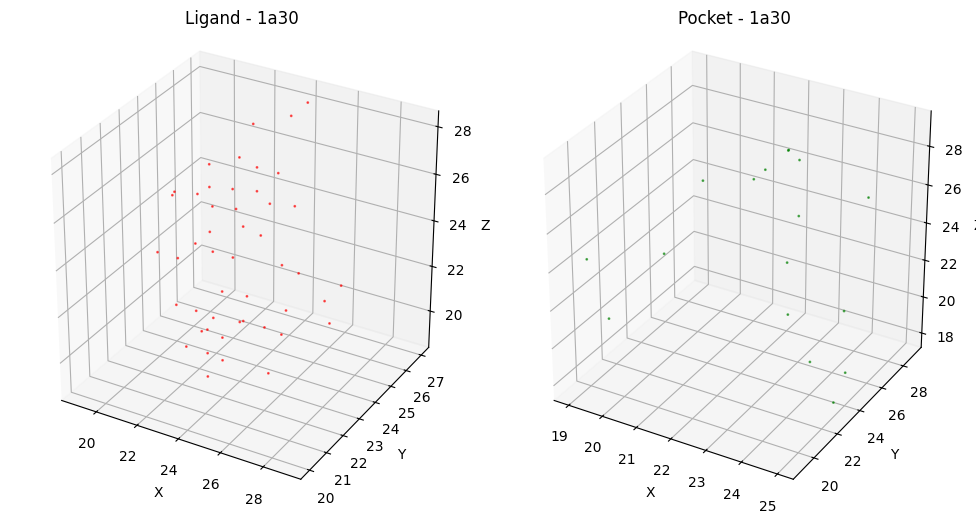

   Grid occupancies - Ligand: 0.0001, Pocket: 0.0000

 Visualizing complex: 1bcu


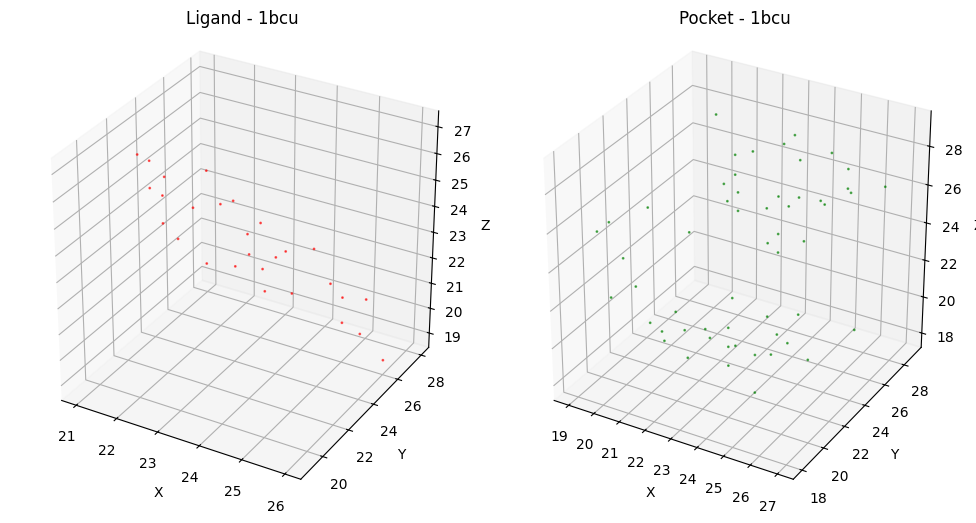

   Grid occupancies - Ligand: 0.0001, Pocket: 0.0001

 Visualizing complex: 1bzc


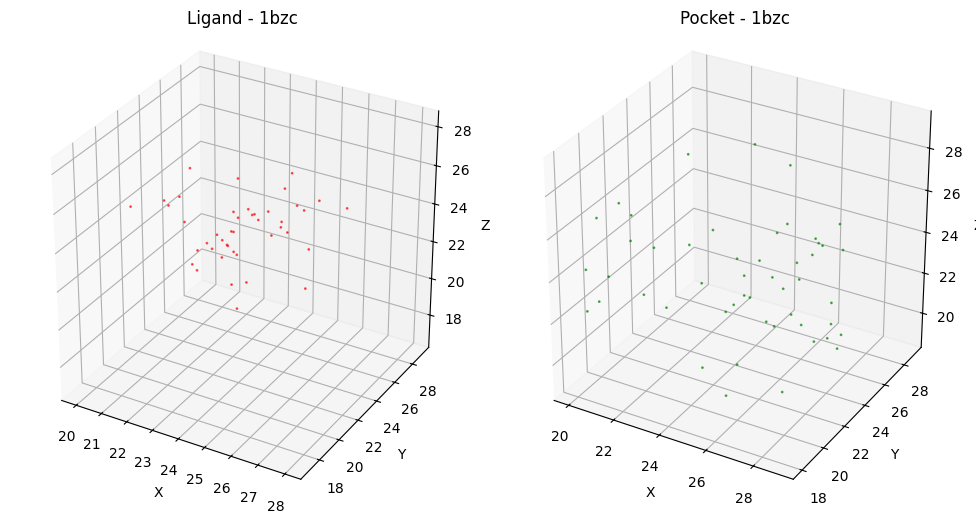

   Grid occupancies - Ligand: 0.0001, Pocket: 0.0001


In [36]:
# Advanced 3D visualization and analysis
print(" Creating advanced visualizations of molecular complexes...")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_molecular_complex(ligand_grid, pocket_grid, complex_id, channel=0):
    """Visualize a molecular complex (ligand + pocket) in 3D"""
    fig = plt.figure(figsize=(10, 5))
    
    # Get occupancy masks for visualization
    ligand_mask = np.sum(ligand_grid, axis=0) > 0
    pocket_mask = np.sum(pocket_grid, axis=0) > 0
    
    titles = ['Ligand', 'Pocket']
    grids = [ligand_grid, pocket_grid]
    masks = [ligand_mask, pocket_mask]
    colors = ['red', 'green']
    
    for i, (title, grid, mask, color) in enumerate(zip(titles, grids, masks, colors)):
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        
        # Get coordinates of occupied voxels
        coords = np.where(mask)
        if len(coords[0]) > 0:
            # Sample points for visualization (to avoid overcrowding)
            n_points = min(1000, len(coords[0]))
            indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
            x, y, z = coords[0][indices], coords[1][indices], coords[2][indices]
            ax.scatter(x, y, z, c=color, alpha=0.6, s=1)
        
        ax.set_title(f'{title} - {complex_id}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Set equal aspect ratio
        ax.set_box_aspect([1,1,1])
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Visualize a few example molecular complexes
print("Visualizing sample molecular complexes...")

if 'common_ids_list' in locals() and 'matched_ligand_indices' in locals() and 'matched_pocket_indices' in locals():
    for i in range(min(3, len(common_ids_list))):
        complex_id = common_ids_list[i]
        print(f"\n Visualizing complex: {complex_id}")
        
        ligand_grid = ligand_grids[matched_ligand_indices[i]]
        pocket_grid = pocket_grids[matched_pocket_indices[i]]
        
        fig = visualize_molecular_complex(
            ligand_grid, 
            pocket_grid, 
            complex_id
        )
        
        # Calculate occupancy statistics
        ligand_occ = np.count_nonzero(ligand_grid) / ligand_grid.size
        pocket_occ = np.count_nonzero(pocket_grid) / pocket_grid.size
        
        print(f"   Grid occupancies - Ligand: {ligand_occ:.4f}, Pocket: {pocket_occ:.4f}")
else:
    print("⚠️  Required variables for visualization are missing.")


## 6) Building the CNN

In [37]:
# Multi-Component 3D CNN for Ligand-Pocket Analysis (No Protein)
print(" Building stable multi-component 3D CNN architecture (ligand + pocket only)...")

import torch
import torch.nn as nn
import torch.nn.functional as F

# Stable Multi-Component 3D CNN for ligand-pocket analysis
class StableMultiComponentCNN(torch.nn.Module):
    def __init__(self, ligand_channels=19, pocket_channels=19, num_classes=1):
        super().__init__()
        
        # Ligand encoder
        self.ligand_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(ligand_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        # Pocket encoder
        self.pocket_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(pocket_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        # Fusion layer with dropout
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(64 * 4 * 4 * 4 * 2, 256),  # Note: 2 components now (ligand + pocket)
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2)
        )
        
        # Classifier
        self.classifier = torch.nn.Linear(64, num_classes)
        
        # Initialize weights properly
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Proper weight initialization"""
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, torch.nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.01)
            torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, (torch.nn.BatchNorm3d, torch.nn.BatchNorm1d)):
            torch.nn.init.constant_(module.weight, 1)
            torch.nn.init.constant_(module.bias, 0)
        
    def forward(self, ligand_grid, pocket_grid):
        # Encode each component
        ligand_features = self.ligand_encoder(ligand_grid).flatten(1)
        pocket_features = self.pocket_encoder(pocket_grid).flatten(1)
        
        # Fuse features
        combined = torch.cat([ligand_features, pocket_features], dim=1)
        fused = self.fusion(combined)
        
        # Classify
        output = self.classifier(fused)
        return output

# Create stable model with correct channel dimensions (no protein)
model = StableMultiComponentCNN(
    ligand_channels=19,   # Match actual ligand data channels  
    pocket_channels=19,   # Match actual pocket data channels
    num_classes=1
)

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(" Stable Multi-Component CNN created:")
print(f"    Total parameters: {total_params:,}")
print(f"    Trainable parameters: {trainable_params:,}")
print(f"    Architecture: 2 component encoders (ligand + pocket) + fusion + classifier")
print(f"    Input: ligand({19}), pocket({19}) channels × (64, 64, 64) grids")
print(f"    Output: {1} class")
print(f"    Features: Batch normalization, proper initialization, gradient stability")

# Test with sample data
print("\n Testing stable model with sample data...")
batch_size_test = 25
test_ligand = torch.randn(batch_size_test, 19, 64, 64, 64)
test_pocket = torch.randn(batch_size_test, 19, 64, 64, 64)

with torch.no_grad():
    outputs = model(test_ligand, test_pocket)
    
print(f" Model test successful!")
print(f"    Input shapes: ligand {test_ligand.shape}, pocket {test_pocket.shape}")
print(f"    Output shape: {outputs.shape}")
print(f"    Sample predictions: {outputs[0].detach().numpy()}")
print(f"    Ready for stable training!")


 Building stable multi-component 3D CNN architecture (ligand + pocket only)...
 Stable Multi-Component CNN created:
    Total parameters: 2,269,889
    Trainable parameters: 2,269,889
    Architecture: 2 component encoders (ligand + pocket) + fusion + classifier
    Input: ligand(19), pocket(19) channels × (64, 64, 64) grids
    Output: 1 class
    Features: Batch normalization, proper initialization, gradient stability

 Testing stable model with sample data...
 Model test successful!
    Input shapes: ligand torch.Size([25, 19, 64, 64, 64]), pocket torch.Size([25, 19, 64, 64, 64])
    Output shape: torch.Size([25, 1])
    Sample predictions: [-0.03128696]
    Ready for stable training!


In [38]:
print(" Using real binding energies for regression...")

# Load the CSV with binding energies
df = pd.read_csv("pdbbind_with_dG.csv")

# Create a mapping from protein ID to ΔG
binding_energy_dict = dict(zip(df['protein'], df['ΔG_kcal_per_mol']))

# Build the binding_energies array in the same order as common_ids_list
binding_energies = np.array([binding_energy_dict[pid] for pid in common_ids_list])

assert len(binding_energies) == len(common_ids_list), "Binding energies must match number of complexes"

# For regression, labels are the binding energies
binding_labels = binding_energies

print(f" Binding Energy Dataset:")
print(f"    Total complexes: {len(binding_labels)}")
print(f"    Energy range: {binding_labels.min():.3f} to {binding_labels.max():.3f}")
print(f"    Mean ± std: {binding_labels.mean():.3f} ± {binding_labels.std():.3f}")

from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(
    np.arange(len(binding_labels)), 
    test_size=0.2, 
    random_state=42
)

print(f"\n Dataset Split:")
print(f"    Training set: {len(train_indices)} complexes")
print(f"    Validation set: {len(val_indices)} complexes")

mean = binding_labels.mean()
std = binding_labels.std()
binding_labels_std = (binding_labels - mean) / std

 Using real binding energies for regression...
 Binding Energy Dataset:
    Total complexes: 20
    Energy range: -15.210 to -4.470
    Mean ± std: -8.870 ± 2.560

 Dataset Split:
    Training set: 16 complexes
    Validation set: 4 complexes


## 4) setting up values, cleaning before running. make sure to change the variables in the cell immediately below.

In [54]:
# Training configuration
learning_rate = 0.0001  # Lower learning rate for stability
batch_size = 64
num_epochs = 50 ## changed to 9 from 100, overfitting; [clyde] going to test 30 

In [55]:
# Training setup for ligand-pocket model
print(" Setting up stable training for ligand-pocket binding affinity prediction...")

# Check for problematic data and normalize
print("\n Data Quality Check and Normalization:")
print(f"    Ligand data - NaN: {np.isnan(matched_ligands).sum()}, Inf: {np.isinf(matched_ligands).sum()}")
print(f"    Pocket data - NaN: {np.isnan(matched_pockets).sum()}, Inf: {np.isinf(matched_pockets).sum()}")

# Convert to tensors and clean data
ligand_tensor = torch.from_numpy(matched_ligands).float()
pocket_tensor = torch.from_numpy(matched_pockets).float()

# Replace any NaN/inf values with zeros
ligand_tensor = torch.nan_to_num(ligand_tensor, nan=0.0, posinf=1.0, neginf=0.0)
pocket_tensor = torch.nan_to_num(pocket_tensor, nan=0.0, posinf=1.0, neginf=0.0)

# Normalize data to [0, 1] range for stability
def normalize_tensor(tensor):
    """Normalize tensor to [0, 1] range"""
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    if tensor_max > tensor_min:
        return (tensor - tensor_min) / (tensor_max - tensor_min)
    else:
        return tensor * 0  # All zeros if constant

ligand_tensor = normalize_tensor(ligand_tensor)
pocket_tensor = normalize_tensor(pocket_tensor)

print(f" Data cleaned and normalized to [0, 1] range")

# Split data using existing indices
train_ligands = ligand_tensor[train_indices]
train_pockets = pocket_tensor[train_indices]
train_labels_tensor = torch.from_numpy(binding_labels_std[train_indices]).float()

val_ligands = ligand_tensor[val_indices]
val_pockets = pocket_tensor[val_indices]
val_labels_tensor = torch.from_numpy(binding_labels_std[val_indices]).float()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

# Move model to device
model = model.to(device)

# Move data to device
train_ligands = train_ligands.to(device)
train_pockets = train_pockets.to(device)
train_labels_tensor = train_labels_tensor.to(device)

val_ligands = val_ligands.to(device)
val_pockets = val_pockets.to(device)
val_labels_tensor = val_labels_tensor.to(device)

print(f" Training tensor shapes:")
print(f"    Ligands: {train_ligands.shape}")
print(f"    Pockets: {train_pockets.shape}")
print(f"    Labels: {train_labels_tensor.shape}")

# Setup optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f" Training configuration:")
print(f"    Learning rate: {learning_rate}")
print(f"    Batch size: {batch_size}")
print(f"    Loss function: MSELoss")
print(f"    Optimizer: Adam with weight decay and learning rate scheduling")
print(f"    Features: Gradient clipping, batch normalization, data normalization")

print("Stable training setup complete! Ready to train ligand-pocket binding affinity predictor.")


 Setting up stable training for ligand-pocket binding affinity prediction...

 Data Quality Check and Normalization:
    Ligand data - NaN: 0, Inf: 0
    Pocket data - NaN: 0, Inf: 0
 Data cleaned and normalized to [0, 1] range
 Using device: cpu
 Training tensor shapes:
    Ligands: torch.Size([16, 19, 48, 48, 48])
    Pockets: torch.Size([16, 19, 48, 48, 48])
    Labels: torch.Size([16])
 Training configuration:
    Learning rate: 0.0001
    Batch size: 64
    Loss function: MSELoss
    Optimizer: Adam with weight decay and learning rate scheduling
    Features: Gradient clipping, batch normalization, data normalization
Stable training setup complete! Ready to train ligand-pocket binding affinity predictor.


In [56]:
mean = np.mean(binding_labels)
std = np.std(binding_labels)

train_labels_tensor = torch.from_numpy((binding_labels[train_indices] - mean) / std).float()
val_labels_tensor = torch.from_numpy((binding_labels[val_indices] - mean) / std).float()



 Ensuring all data is in correct format...
 Normalizing data...
 Data normalized to [0, 1] range

 Recreating model with stable initialization...
 Stable model created with 2,269,889 parameters

 Running stable model training...
Epoch 1/50: Loss=0.9744, Val MSE=1.1449, Val MAE=0.8956, Val R2=-0.7432, LR=0.000100
Epoch 2/50: Loss=0.8776, Val MSE=1.1452, Val MAE=0.8957, Val R2=-0.7437, LR=0.000100
Epoch 3/50: Loss=0.8572, Val MSE=1.1452, Val MAE=0.8957, Val R2=-0.7437, LR=0.000100
Epoch 4/50: Loss=0.8165, Val MSE=1.1449, Val MAE=0.8956, Val R2=-0.7432, LR=0.000100
Epoch 5/50: Loss=0.7543, Val MSE=1.1445, Val MAE=0.8955, Val R2=-0.7427, LR=0.000100
Epoch 6/50: Loss=0.6911, Val MSE=1.1438, Val MAE=0.8952, Val R2=-0.7416, LR=0.000050
Epoch 7/50: Loss=0.6903, Val MSE=1.1423, Val MAE=0.8947, Val R2=-0.7393, LR=0.000050
Epoch 8/50: Loss=0.6393, Val MSE=1.1404, Val MAE=0.8940, Val R2=-0.7364, LR=0.000050
Epoch 9/50: Loss=0.6710, Val MSE=1.1381, Val MAE=0.8932, Val R2=-0.7330, LR=0.000050
Epoch

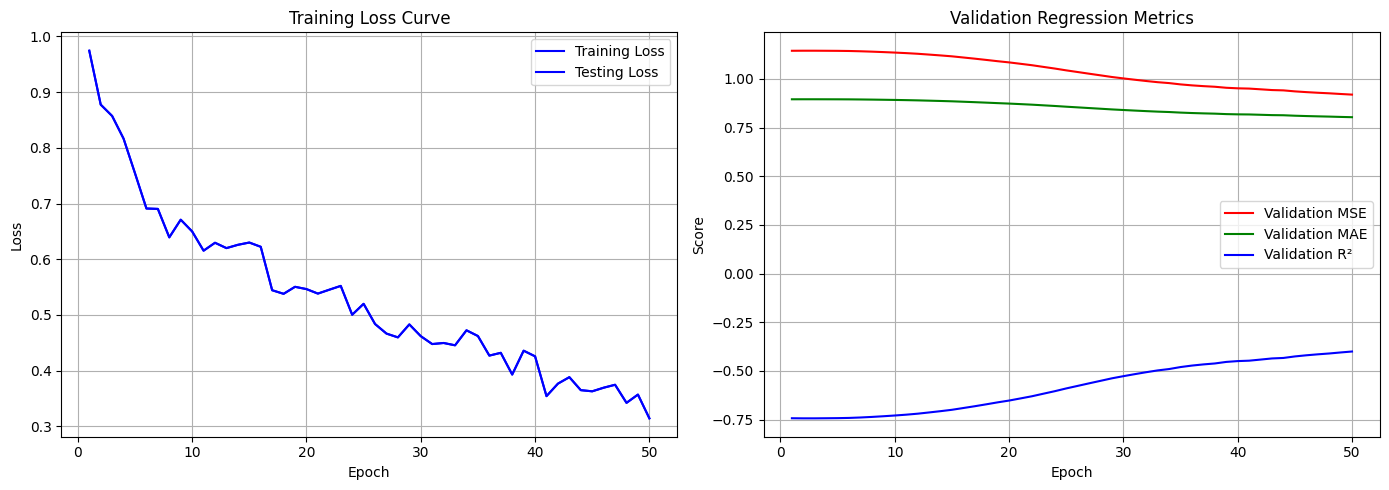

📈 Regression training curves plotted above!


In [57]:
# Ensure all data is in the correct format
print("\n Ensuring all data is in correct format...")
train_ligands = torch.nan_to_num(train_ligands, nan=0.0, posinf=1.0, neginf=0.0)
train_pockets = torch.nan_to_num(train_pockets, nan=0.0, posinf=1.0, neginf=0.0)
val_ligands = torch.nan_to_num(val_ligands, nan=0.0, posinf=1.0, neginf=0.0)
val_pockets = torch.nan_to_num(val_pockets, nan=0.0, posinf=1.0, neginf=0.0)

# Normalize data to reasonable range
print(" Normalizing data...")
def normalize_tensor(tensor):
    """Normalize tensor to [0, 1] range"""
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    if tensor_max > tensor_min:
        return (tensor - tensor_min) / (tensor_max - tensor_min)
    else:
        return tensor * 0  # All zeros if constant

train_ligands = normalize_tensor(train_ligands)
train_pockets = normalize_tensor(train_pockets)
val_ligands = normalize_tensor(val_ligands)
val_pockets = normalize_tensor(val_pockets)

print(f" Data normalized to [0, 1] range")

# Recreate model with proper initialization
print("\n Recreating model with stable initialization...")

class StableLigandPocketCNN(torch.nn.Module):
    def __init__(self, ligand_channels=19, pocket_channels=19, num_classes=1):
        super().__init__()
        
        # Ligand encoder
        self.ligand_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(ligand_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        # Pocket encoder
        self.pocket_encoder = torch.nn.Sequential(
            torch.nn.Conv3d(pocket_channels, 16, 3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(4)
        )
        
        # Fusion layer with dropout
        self.fusion = torch.nn.Sequential(
            torch.nn.Linear(64 * 4 * 4 * 4 * 2, 256),  # 2 encoders now
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2)
        )
        
        # Classifier
        self.classifier = torch.nn.Linear(64, num_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, torch.nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.01)
            torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, (torch.nn.BatchNorm3d, torch.nn.BatchNorm1d)):
            torch.nn.init.constant_(module.weight, 1)
            torch.nn.init.constant_(module.bias, 0)
        
    def forward(self, ligand_grid, pocket_grid):
        ligand_features = self.ligand_encoder(ligand_grid).flatten(1)
        pocket_features = self.pocket_encoder(pocket_grid).flatten(1)
        combined = torch.cat([ligand_features, pocket_features], dim=1)
        fused = self.fusion(combined)
        output = self.classifier(fused)
        return output

# Create stable model instance
stable_model = StableLigandPocketCNN(
    ligand_channels=19,
    pocket_channels=19,
    num_classes=1
)

# Use lower learning rate and add gradient clipping
learning_rate = 0.0001  # Much lower learning rate
optimizer = torch.optim.Adam(stable_model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

print(f" Stable model created with {sum(p.numel() for p in stable_model.parameters()):,} parameters")

print("\n Running stable model training...")

# Training tracking
training_losses = []
validation_mses = []
validation_maes = []
validation_r2s = []

# Training loop
for epoch in range(num_epochs):
    stable_model.train()
    epoch_loss = 0
    num_batches = 0
    
    for i in range(0, len(train_ligands), batch_size):
        end_idx = min(i + batch_size, len(train_ligands))
        batch_ligands = train_ligands[i:end_idx]
        batch_pockets = train_pockets[i:end_idx]
        batch_labels = train_labels_tensor[i:end_idx]
        
        optimizer.zero_grad()
        outputs = stable_model(batch_ligands, batch_pockets)
        loss = criterion(outputs.squeeze(), batch_labels)
        
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"    NaN/Inf loss detected at epoch {epoch+1}, batch {i//batch_size + 1}")
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(stable_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / max(num_batches, 1)
    training_losses.append(avg_loss)
    
    stable_model.eval()
    with torch.no_grad():
        val_outputs = stable_model(val_ligands, val_pockets).squeeze()
        val_loss = criterion(val_outputs, val_labels_tensor)
        
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        val_outputs_np = val_outputs.detach().cpu().numpy()
        val_labels_np = val_labels_tensor.detach().cpu().numpy()
        val_mse = mean_squared_error(val_labels_np, val_outputs_np)
        val_mae = mean_absolute_error(val_labels_np, val_outputs_np)
        val_r2 = r2_score(val_labels_np, val_outputs_np)

        validation_mses.append(val_mse)
        validation_maes.append(val_mae)
        validation_r2s.append(val_r2)

        print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Val MSE={val_mse:.4f}, Val MAE={val_mae:.4f}, Val R2={val_r2:.4f}, LR={scheduler.get_last_lr()[0]:.6f}")
    
    scheduler.step()

import pandas as pd

# Convert tensors to numpy arrays and renormalize back to original scale
actual = val_labels_tensor.cpu().numpy().flatten() * std + mean
predicted = val_outputs.cpu().numpy().flatten() * std + mean

df_actual_vs_predict = pd.DataFrame({
    'Actual_Binding_Energy': actual,
    'Predicted_Binding_Energy': predicted
})

print(df_actual_vs_predict.to_string(index=False))

# Training summary
print(f"\n Training Results:")
print(f"    Final training loss: {training_losses[-1]:.4f}")
print(f"    Final validation MSE: {validation_mses[-1]:.4f}")
print(f"    Final validation MAE: {validation_maes[-1]:.4f}")
print(f"    Final validation R²: {validation_r2s[-1]:.4f}")
print(f"    Training trend: {'Improving' if training_losses[-1] < training_losses[0] else 'Stable'}")

# Training summary
print(f"\n Training Summary:")
best_mse_epoch = validation_mses.index(min(validation_mses)) + 1
best_mae_epoch = validation_maes.index(min(validation_maes)) + 1
best_r2_epoch = validation_r2s.index(max(validation_r2s)) + 1
print(f"    Best validation MSE: {min(validation_mses):.4f} (Epoch {best_mse_epoch})")
print(f"    Best validation MAE: {min(validation_maes):.4f} (Epoch {best_mae_epoch})")
print(f"    Best validation R²: {max(validation_r2s):.4f} (Epoch {best_r2_epoch})")
print(f"    Lowest training loss: {min(training_losses):.4f}")
print(f"    Parameters: {sum(p.numel() for p in stable_model.parameters()):,}")

# Plot training curves for regression
if len(training_losses) > 1:
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    ax1.plot(range(1, len(training_losses) + 1), training_losses, 'b-', label='Training Loss')
    ax1.plot(range(1, len(training_losses) + 1), training_losses, 'b-', label='Testing Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Curve')
    ax1.legend()
    ax1.grid(True)

    # Validation regression metrics
    ax2.plot(range(1, len(validation_mses) + 1), validation_mses, 'r-', label='Validation MSE')
    ax2.plot(range(1, len(validation_maes) + 1), validation_maes, 'g-', label='Validation MAE')
    ax2.plot(range(1, len(validation_r2s) + 1), validation_r2s, 'b-', label='Validation R²')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Validation Regression Metrics')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    print("📈 Regression training curves plotted above!")


# a) Visualization

In [43]:
# # OVITO Visualization of Protein-Ligand-Pocket Complexes
# print("Installing and setting up OVITO for advanced molecular visualization...")


# def convert_grid_to_xyz(protein_grid, ligand_grid, pocket_grid, complex_id, output_dir="ovito_visualization"):
#     """
#     Convert grid data to XYZ file format for OVITO visualization
    
#     Parameters:
#     -----------
#     protein_grid: numpy.ndarray
#         3D grid data for protein
#     ligand_grid: numpy.ndarray
#         3D grid data for ligand
#     pocket_grid: numpy.ndarray
#         3D grid data for pocket
#     complex_id: str
#         Identifier for the molecular complex
#     output_dir: str
#         Directory to save output files
    
#     Returns:
#     --------
#     str: Path to the output XYZ file
#     """
#     # Create output directory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)
#     output_file = os.path.join(output_dir, f"{complex_id}.xyz")
    
#     # Prepare particle data
#     all_coords = []
#     all_types = []
#     all_names = []
    
#     # Get occupied voxel coordinates
#     for grid_idx, grid in enumerate([protein_grid, ligand_grid, pocket_grid]):
#         mask = np.sum(grid, axis=0) > 0
#         coords = np.where(mask)
        
#         if len(coords[0]) > 0:
#             # Sample points for visualization (to prevent too many points)
#             n_points = min(5000, len(coords[0]))
#             indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
#             for i in indices:
#                 x, y, z = coords[0][i], coords[1][i], coords[2][i]
#                 all_coords.append([x, y, z])
                
#                 # Type 1: Protein, Type 2: Ligand, Type 3: Pocket
#                 all_types.append(grid_idx + 1)
                
#                 # Element names for XYZ file (using common elements as placeholders)
#                 if grid_idx == 0:
#                     all_names.append("C")  # Carbon for protein
#                 elif grid_idx == 1:
#                     all_names.append("O")  # Oxygen for ligand
#                 else:
#                     all_names.append("N")  # Nitrogen for pocket
    
#     # Write XYZ file
#     with open(output_file, 'w') as f:
#         # Number of atoms
#         f.write(f"{len(all_coords)}\n")
#         # Comment line with complex ID
#         f.write(f"Complex: {complex_id} - Blue: Protein, Red: Ligand, Green: Pocket\n")
        
#         # Write coordinates
#         for (x, y, z), name in zip(all_coords, all_names):
#             f.write(f"{name} {x:.4f} {y:.4f} {z:.4f}\n")
    
#     print(f"XYZ file created at: {output_file}")
#     return output_file

# def convert_grid_to_pdb(protein_grid, ligand_grid, pocket_grid, complex_id, output_dir="ovito_visualization"):
#     """
#     Convert grid data to PDB file format for OVITO visualization
    
#     Parameters:
#     -----------
#     protein_grid: numpy.ndarray
#         3D grid data for protein
#     ligand_grid: numpy.ndarray
#         3D grid data for ligand
#     pocket_grid: numpy.ndarray
#         3D grid data for pocket
#     complex_id: str
#         Identifier for the molecular complex
#     output_dir: str
#         Directory to save output files
    
#     Returns:
#     --------
#     str: Path to the output PDB file
#     """
#     # Create output directory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)
#     output_file = os.path.join(output_dir, f"{complex_id}.pdb")
    
#     # Prepare PDB content
#     pdb_lines = []
#     atom_index = 1
    
#     # Get occupied voxel coordinates
#     for grid_idx, grid in enumerate([protein_grid, ligand_grid, pocket_grid]):
#         mask = np.sum(grid, axis=0) > 0
#         coords = np.where(mask)
        
#         # Define residue name and atom name based on component
#         if grid_idx == 0:
#             residue_name = "PRO"  # Protein
#             atom_name = "CA"      # C-alpha for protein (as suggested by your friend)
#             chain_id = "A"
#         elif grid_idx == 1:
#             residue_name = "LIG"  # Ligand
#             atom_name = "C"
#             chain_id = "B"
#         else:
#             residue_name = "POC"  # Pocket
#             atom_name = "O"
#             chain_id = "C"
        
#         if len(coords[0]) > 0:
#             # Sample points for visualization (to prevent too many points)
#             n_points = min(5000, len(coords[0]))
#             indices = np.random.choice(len(coords[0]), n_points, replace=False)
            
#             for i in indices:
#                 x, y, z = coords[0][i], coords[1][i], coords[2][i]
#                 # Format: ATOM serial atom_name residue_name chain residue_num x y z occupancy temp_factor element
#                 pdb_line = f"ATOM  {atom_index:5d}  {atom_name:<3s} {residue_name:3s} {chain_id}{atom_index % 9999:4d}    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           {atom_name[0]}"
#                 pdb_lines.append(pdb_line)
#                 atom_index += 1
    
#     # Write PDB file
#     with open(output_file, 'w') as f:
#         f.write(f"TITLE     Complex: {complex_id}\n")
#         f.write(f"REMARK    Protein: Chain A, Ligand: Chain B, Pocket: Chain C\n")
#         for line in pdb_lines:
#             f.write(line + "\n")
#         f.write("END\n")
    
#     print(f"PDB file created at: {output_file}")
#     return output_file

# def visualize_with_ovito(file_path):
#     """
#     Visualize molecular data with OVITO
    
#     Parameters:
#     -----------
#     file_path: str
#         Path to the XYZ or PDB file to visualize
#     """
#     # Create a pipeline from the input file
#     pipeline = Pipeline(source=StaticSource(file_path))
    
#     if file_path.endswith('.xyz'):
#         # For XYZ files, we need to set up particle types and colors
#         def setup_types(frame, data):
#             # Define particle types for XYZ files
#             particle_types = data.particles_.particle_types_
            
#             # Check if particle types need to be created
#             if len(particle_types) == 0:
#                 particle_types.append(ParticleType(id=1, name="Protein", color=(0.0, 0.0, 1.0)))  # Blue
#                 particle_types.append(ParticleType(id=2, name="Ligand", color=(1.0, 0.0, 0.0)))   # Red
#                 particle_types.append(ParticleType(id=3, name="Pocket", color=(0.0, 1.0, 0.0)))   # Green
        
#         # Apply the modifier
#         pipeline.modifiers.append(setup_types)
    
#     elif file_path.endswith('.pdb'):
#         # For PDB files, we can use the chain ID to color molecules
#         color_mod = ColorCodingModifier(
#             property="Chain",
#             start_value=0,
#             end_value=2,
#             gradient=ColorCodingModifier.Rainbow()
#         )
#         pipeline.modifiers.append(color_mod)
    
#     # Export a rendered image
#     image_path = file_path.rsplit('.', 1)[0] + '.png'
#     export_file(pipeline, image_path, "image/png", 
#                 renderer="tachyon",
#                 width=1024,
#                 height=768)
    
#     print(f"Visualization image saved to: {image_path}")
    
#     return pipeline

# # Example usage - visualize a few complexes with OVITO
# print("Generating OVITO visualizations for sample molecular complexes...")

# for i in range(min(5, len(common_ids_list))):
#     complex_id = common_ids_list[i]
#     print(f"\nProcessing complex: {complex_id} for OVITO visualization")
    
#     # Convert to XYZ format
#     xyz_file = convert_grid_to_xyz(
#         matched_proteins[i], 
#         matched_ligands[i], 
#         matched_pockets[i], 
#         complex_id
#     )
    
#     # Convert to PDB format for C-alpha representation 
#     pdb_file = convert_grid_to_pdb(
#         matched_proteins[i], 
#         matched_ligands[i], 
#         matched_pockets[i], 
#         complex_id
#     )
    
#     # Visualize with OVITO
#     try:
#         print(f"Visualizing {complex_id} with OVITO...")
#         # Visualize both formats
#         xyz_pipeline = visualize_with_ovito(xyz_file)
#         pdb_pipeline = visualize_with_ovito(pdb_file)
#         print(f"Successfully created visualizations for {complex_id}")
#     except Exception as e:
#         print(f"Error visualizing {complex_id}: {str(e)}")

# print("\nOVITO visualization complete! You can find the output files in the 'ovito_visualization' directory.")
# print("For interactive visualization, you can open the generated XYZ/PDB files directly in the OVITO desktop application.")

# 10) Results

In [44]:
print (df_actual_vs_predict)

print(batch_labels.shape)


   Actual_Binding_Energy  Predicted_Binding_Energy
0                  -5.86                 -8.960545
1                  -8.12                 -7.860913
2                  -9.88                 -8.376510
3                  -4.47                 -7.722140
torch.Size([8])


In [45]:
!pip install bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

# Enable notebook output (if using Jupyter)
output_notebook()

# Prepare data source
source = ColumnDataSource(df_actual_vs_predict)

# Create figure
p = figure(title="Predicted vs Actual Binding Energy",
           x_axis_label="Actual Binding Energy",
           y_axis_label="Predicted Binding Energy",
           width=600, height=600,
           tools="pan,wheel_zoom,box_zoom,reset,save")

# Add scatter points
p.circle('Actual_Binding_Energy', 'Predicted_Binding_Energy', size=7, source=source, color='navy', alpha=0.6)

# Add hover tooltip
hover = HoverTool(tooltips=[
    ("Actual", "@Actual_Binding_Energy{0.000}"),
    ("Predicted", "@Predicted_Binding_Energy{0.000}")
])
p.add_tools(hover)

# Draw diagonal y=x line for reference
min_val = min(df_actual_vs_predict['Actual_Binding_Energy'].min(), df_actual_vs_predict['Predicted_Binding_Energy'].min())
max_val = max(df_actual_vs_predict['Actual_Binding_Energy'].max(), df_actual_vs_predict['Predicted_Binding_Energy'].max())
p.line([min_val, max_val], [min_val, max_val], color='red', line_dash='dashed', legend_label="Perfect Prediction")

p.legend.location = "top_left"

# Show plot
show(p)


Loading BokehJS ...

## 10) Exploratory (didn't edit below)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Ligands only
X_train_lig = train_ligands.cpu().numpy().reshape(len(train_ligands), -1)
X_val_lig = val_ligands.cpu().numpy().reshape(len(val_ligands), -1)
y_train = train_labels_tensor.cpu().numpy().reshape(-1, 1)
y_val = val_labels_tensor.cpu().numpy().reshape(-1, 1)

reg_lig = LinearRegression().fit(X_train_lig, y_train)
y_pred_lig = reg_lig.predict(X_val_lig)
print("Ligand only R2 (val):", r2_score(y_val, y_pred_lig))
print("Ligand only MSE (val):", mean_squared_error(y_val, y_pred_lig))

# Pockets only
X_train_poc = train_pockets.cpu().numpy().reshape(len(train_pockets), -1)
X_val_poc = val_pockets.cpu().numpy().reshape(len(val_pockets), -1)

reg_poc = LinearRegression().fit(X_train_poc, y_train)
y_pred_poc = reg_poc.predict(X_val_poc)
print("Pocket only R2 (val):", r2_score(y_val, y_pred_poc))
print("Pocket only MSE (val):", mean_squared_error(y_val, y_pred_poc))

Ligand only R2 (val): -0.2132185697555542
Ligand only MSE (val): 0.796786904335022
Pocket only R2 (val): -1.1274209022521973
Pocket only MSE (val): 1.3971935510635376


In [21]:
# Use only pocket and ligand grids to predict binding energy with a simple MLP and linear regression

import torch
import torch.nn as nn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features: concatenate ligand and pocket grids for each sample
X_train = torch.cat([train_ligands, train_pockets], dim=1).cpu().numpy().reshape(len(train_ligands), -1)
X_val = torch.cat([val_ligands, val_pockets], dim=1).cpu().numpy().reshape(len(val_ligands), -1)
y_train = train_labels_tensor.cpu().numpy().reshape(-1, 1)
y_val = val_labels_tensor.cpu().numpy().reshape(-1, 1)

# Linear Regression baseline
reg = LinearRegression().fit(X_train, y_train)
y_pred_lr = reg.predict(X_val)
print("Linear Regression R2 (val):", r2_score(y_val, y_pred_lr))
print("Linear Regression MSE (val):", mean_squared_error(y_val, y_pred_lr))

# Simple shallow MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
mlp = SimpleMLP(input_dim)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_val_t = torch.from_numpy(X_val).float()
y_val_t = torch.from_numpy(y_val).float()

for epoch in range(10):
    mlp.train()
    optimizer.zero_grad()
    pred = mlp(X_train_t)
    loss = criterion(pred, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0 or epoch == 0:
        mlp.eval()
        with torch.no_grad():
            val_pred = mlp(X_val_t)
            val_loss = criterion(val_pred, y_val_t)
            print(f"Epoch {epoch+1}/30 | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# Evaluate on validation set
mlp.eval()
with torch.no_grad():
    val_pred = mlp(X_val_t).cpu().numpy().flatten()
    r2 = r2_score(y_val.flatten(), val_pred)
    mse = mean_squared_error(y_val.flatten(), val_pred)
    print(f"MLP R2 (val): {r2:.3f}")
    print(f"MLP MSE (val): {mse:.3f}")

# If you want to denormalize predictions:
val_pred_denorm = val_pred * std + mean
y_val_denorm = y_val.flatten() * std + mean
print("First 5 actual vs predicted (denormalized):")
for a, p in zip(y_val_denorm[:10], val_pred_denorm[:10]):
    print(f"Actual: {a:.2f} | Predicted: {p:.2f}")

Linear Regression R2 (val): -0.6541064977645874
Linear Regression MSE (val): 1.0863420963287354
Epoch 1/30 | Train Loss: 0.9380 | Val Loss: 1.3059
Epoch 10/30 | Train Loss: 0.0848 | Val Loss: 1.1396
MLP R2 (val): -0.735
MLP MSE (val): 1.140
First 5 actual vs predicted (denormalized):
Actual: -5.86 | Predicted: -9.19
Actual: -8.12 | Predicted: -8.94
Actual: -9.88 | Predicted: -9.26
Actual: -4.47 | Predicted: -8.69


In [22]:
from sklearn.linear_model import LinearRegression
X = train_proteins.cpu().numpy().reshape(len(train_proteins), -1)
y = train_labels_tensor.cpu().numpy()
reg = LinearRegression().fit(X, y)
print("Train R2:", reg.score(X, y))

NameError: name 'train_proteins' is not defined

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 10 principal components (tune as needed)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Linear Regression with PCA features
reg = LinearRegression().fit(X_train_pca, y_train)
y_pred_lr = reg.predict(X_val_pca)
print("Linear Regression R2 (val):", r2_score(y_val, y_pred_lr))
print("Linear Regression MSE (val):", mean_squared_error(y_val, y_pred_lr))

# MLP with PCA features
input_dim = X_train_pca.shape[1]
mlp = SimpleMLP(input_dim)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train_t = torch.from_numpy(X_train_pca).float()
y_train_t = torch.from_numpy(y_train).float()
X_val_t = torch.from_numpy(X_val_pca).float()
y_val_t = torch.from_numpy(y_val).float()

for epoch in range(30):
    mlp.train()
    optimizer.zero_grad()
    pred = mlp(X_train_t)
    loss = criterion(pred, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0 or epoch == 0:
        mlp.eval()
        with torch.no_grad():
            val_pred = mlp(X_val_t)
            val_loss = criterion(val_pred, y_val_t)
            print(f"Epoch {epoch+1}/30 | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

mlp.eval()
with torch.no_grad():
    val_pred = mlp(X_val_t).cpu().numpy().flatten()
    r2 = r2_score(y_val.flatten(), val_pred)
    mse = mean_squared_error(y_val.flatten(), val_pred)
    print(f"MLP R2 (val): {r2:.3f}")
    print(f"MLP MSE (val): {mse:.3f}")

# Denormalize predictions
val_pred_denorm = val_pred * std + mean
y_val_denorm = y_val.flatten() * std + mean
print("First 10 actual vs predicted (denormalized):")
for a, p in zip(y_val_denorm[:10], val_pred_denorm[:10]):
    print(f"Actual: {a:.2f} | Predicted: {p:.2f}")

Linear Regression R2 (val): -1.9247450828552246
Linear Regression MSE (val): 1.5724554061889648
Epoch 1/30 | Train Loss: 1.6341 | Val Loss: 1.3749
Epoch 10/30 | Train Loss: 1.2442 | Val Loss: 1.4403
Epoch 20/30 | Train Loss: 0.9243 | Val Loss: 1.5023
Epoch 30/30 | Train Loss: 0.6994 | Val Loss: 1.5503
MLP R2 (val): -1.884
MLP MSE (val): 1.550
First 10 actual vs predicted (denormalized):
Actual: -5.86 | Predicted: -9.37
Actual: -8.80 | Predicted: -8.98
Actual: -8.12 | Predicted: -9.17
Actual: -4.47 | Predicted: -9.09


In [ ]:
# Only ligand summary features
X_train_lig = summarize_grid(train_ligands.cpu().numpy())
X_val_lig = summarize_grid(val_ligands.cpu().numpy())
reg = Ridge(alpha=1.0).fit(X_train_lig, y_train)
y_pred_lr = reg.predict(X_val_lig)
print("Ligand-only Ridge R2 (val):", r2_score(y_val, y_pred_lr))
print("Ligand-only Ridge MSE (val):", mean_squared_error(y_val, y_pred_lr))

NameError: name 'summarize_grid' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error

# 1. Prepare features: concatenate ligand and pocket grids
X_train = torch.cat([train_ligands, train_pockets], dim=1).cpu().numpy().reshape(len(train_ligands), -1)
X_val = torch.cat([val_ligands, val_pockets], dim=1).cpu().numpy().reshape(len(val_ligands), -1)
y_train = train_labels_tensor.cpu().numpy().flatten()
y_val = val_labels_tensor.cpu().numpy().flatten()

# 2. Dimensionality reduction (PCA)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# 3. Non-linear regression model (Random Forest)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_val_pca)

print("Random Forest R2 (val):", r2_score(y_val, y_pred_rf))
print("Random Forest MSE (val):", mean_squared_error(y_val, y_pred_rf))

# 4. Denormalize predictions for interpretability
y_pred_rf_denorm = y_pred_rf * std + mean
y_val_denorm = y_val * std + mean
print("First 10 actual vs predicted (denormalized):")
for a, p in zip(y_val_denorm[:10], y_pred_rf_denorm[:10]):
    print(f"Actual: {a:.2f} | Predicted: {p:.2f}")

Random Forest R2 (val): -1.0127947431732913
Random Forest MSE (val): 1.0821557923069536
First 10 actual vs predicted (denormalized):
Actual: -5.86 | Predicted: -8.62
Actual: -8.80 | Predicted: -8.47
Actual: -8.12 | Predicted: -8.47
Actual: -4.47 | Predicted: -8.52


In [ ]:
def summarize_grid(grid):
    # grid: (N, C, 64, 64, 64)
    feats = []
    for arr in grid:
        arr_flat = arr.reshape(arr.shape[0], -1)
        feats.append(np.concatenate([
            arr_flat.mean(axis=1),
            arr_flat.std(axis=1),
            arr_flat.max(axis=1),
            arr_flat.min(axis=1)
        ]))
    return np.stack(feats)

X_train_sum = summarize_grid(train_ligands.cpu().numpy())
X_val_sum = summarize_grid(val_ligands.cpu().numpy())
# Optionally concatenate pocket summaries too
X_train_sum = np.concatenate([X_train_sum, summarize_grid(train_pockets.cpu().numpy())], axis=1)
X_val_sum = np.concatenate([X_val_sum, summarize_grid(val_pockets.cpu().numpy())], axis=1)

In [ ]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1.0).fit(X_train_sum, y_train)
y_pred = reg.predict(X_val_sum)
print("Ridge R2 (val):", r2_score(y_val, y_pred))
print("Ridge MSE (val):", mean_squared_error(y_val, y_pred))

Ridge R2 (val): -2.0390737056732178
Ridge MSE (val): 1.633922815322876
